In [28]:
# Python Library
import os, glob, sys
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.time import Time
import warnings
warnings.filterwarnings("ignore")

# Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
#
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

In [29]:
# scp -P7777 gp@210.117.217.72:/large_data/processed/UDS/7DT06/m600/summary.csv .

In [30]:
n_sigma = 3

In [31]:
# filte = 'm600'
filte = 'm575'
# filte = 'm700'
# filte = 'm675'

In [32]:
path_save = f"../output/UDS/{filte}"
if not os.path.exists(path_save): os.makedirs(path_save)

In [33]:
intbl = Table.read(f"../data/UDS/{filte}/summary.csv", format='csv')
intbl['row_index'] = np.arange(len(intbl))
intbl[:3]

file,simple,bitpix,naxis,naxis1,naxis2,extend,origin,date,imagetyp,exposure,exptime,date-loc,date-obs,xbinning,ybinning,gain,egain,xpixsz,ypixsz,instrume,set-temp,ccd-temp,telescop,focallen,focratio,ra,dec,centalt,centaz,airmass,pierside,siteelev,sitelat,sitelong,fwheel,filter,object,objctra,objctdec,objctrot,focname,focpos,focuspos,focussz,roworder,equinox,swcreate,radesys,ctype1,ctype2,cunit1,cunit2,crval1,crval2,crpix1,crpix2,cd1_1,cd1_2,cd2_1,cd2_2,pv1_0,pv1_1,pv1_2,pv1_4,pv1_5,pv1_6,pv1_7,pv1_8,pv1_9,pv1_10,pv2_0,pv2_1,pv2_2,pv2_4,pv2_5,pv2_6,pv2_7,pv2_8,pv2_9,pv2_10,fgroupno,astirms1,astirms2,astrrms1,astrrms2,astinst,flxscale,magzerop,photirms,photinst,photlink,racent,deccent,rapoly0,depoly0,rapoly1,depoly1,rapoly2,depoly2,rapoly3,depoly3,rotang1,rotang2,author,photime,jd,mjd,seeing,peeing,ellip,elong,skysig,skyval,refcat,maglow,magup,stdnumb,auto,aper,aper_1,aper_2,aper_3,aper_4,aper_5,zp_auto,ezp_auto,ul3_auto,ul5_auto,zp_0,ezp_0,ul3_0,ul5_0,zp_1,ezp_1,ul3_1,ul5_1,zp_2,ezp_2,ul3_2,ul5_2,zp_3,ezp_3,ul3_3,ul5_3,zp_4,ezp_4,ul3_4,ul5_4,zp_5,ezp_5,ul3_5,ul5_5,comment,history,cloudcvr,dewpoint,humidity,pressure,skybrght,mpsas,skytemp,starfwhm,ambtemp,winddir,windgust,windspd,row_index
str81,str4,int64,int64,int64,int64,str4,str27,str23,str5,float64,float64,str23,str23,int64,int64,int64,float64,float64,float64,str19,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,str19,str4,str3,str8,str9,float64,str20,int64,int64,float64,str8,float64,str19,str4,str8,str8,str3,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str17,str10,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str64,str57,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
/large_data/processed/UDS/7DT05/m575/calib_7DT05_UDS_20231023_075852_m575_60.fits,True,-32,2,9576,6388,True,Eclair v0.9 25 October 2019,2023-12-25T18:18:14.973,LIGHT,60.0,60.0,2023-10-23T04:58:52.949,2023-10-23T07:58:52.949,1,1,2750,0.256190478801727,3.76,3.76,Moravian USB Camera,-10.0,-10.1511306762695,7DT05,1537.0,3.0,34.4041592321362,-5.05362485739673,39.8254524584717,291.112622157965,1.55924182485279,East,1600.0,-30.4713333333333,-70.7649444444445,Moravian USB Filter,m575,UDS,02 17 37,-05 03 13,0.0,PlaneWave Focuser (v,6300,6300,1.0,TOP-DOWN,2000.0,N.I.N.A. 2.2.0.9001,ICRS,RA---TPV,DEC--TPV,deg,deg,34.41021191384,-5.05286132689,4788.5,3194.5,0.0001401026855108,-9.363930752122e-06,9.353772277174e-06,0.0001401747771331,9.695377273535e-05,1.001262135993,0.0001477368611883,-0.0003028622166311,-1.904316810254e-06,-0.0002793482308649,-0.004294787695519,-0.0001652287286506,-0.00374451542046,-0.0003766376988424,1.091622214645e-05,1.000397226108,3.702526436699e-05,-0.0003992601502955,-0.0001774508459299,6.827041931119e-05,-0.004114540523338,-0.0004367177720037,-0.003989939749449,-8.200989123394e-05,1,2.979467620871e-05,2.753312534353e-05,3.689827555076e-05,3.664781685257e-05,1,0.01666830078327,0.0,0.12938513,1,False,34.41,-5.053,33.767,-5.544,35.113,-5.454,33.708,-4.65,35.052,-4.561,-3.823745144150574,3.817650626934587,Gregory S.H. Paek,2023-12-26,2460240.83255728,60240.33255728009,3.548,7.027,0.313,1.456,8.532,12.073,GaiaXP,12.0,20.0,174,0.0,9.459,14.053,21.08,5.941,9.901,19.802,24.821,0.087,0.0,0.0,24.22,0.085,18.392,17.837,24.539,

# Selection

### Step 1: Specific Date

In [34]:
select_date_dict = {
	'm600': ['202310', '20231105_024902',],
	'm575': ['202310',],
	'm700': [],
	'm675': ['202310'],
}

In [35]:
select_time_range_dict = {
	'm600': None,
	'm575': ['20231106_060913', '20231106_080527'],
	'm700': ['20231104_024729', '20231104_045605'],
	'm675': None,
}

In [36]:
patterns = select_date_dict[filte]

In [37]:
pattern_range = select_time_range_dict[filte]
if pattern_range == None:
	_intbl = intbl.copy()
	_n_out = 0
else:
	pattern_min, pattern_max = pattern_range

	for mm, inim in enumerate(intbl['file']):
		if pattern_min in inim:
			print(f"[{mm}] {inim}")
			indx_min_date = mm
		if pattern_max in inim:
			print(f"[{mm}] {inim}")
			indx_max_date = mm

	_intbl = intbl[(intbl['row_index']<=indx_min_date) | (intbl['row_index']>=indx_max_date)]
	print(f"{len(_intbl)} Selected Among {len(intbl)}")
	_n_out = len(intbl) - len(_intbl)

[576] /large_data/processed/UDS/7DT05/m575/calib_7DT05_UDS_20231106_060913_m575_60.fits
[682] /large_data/processed/UDS/7DT05/m575/calib_7DT05_UDS_20231106_080527_m575_60.fits
1138 Selected Among 1243


In [38]:
n_total = len(intbl)

n_out = 0
indx_step1 = []

for nn, inim in enumerate(_intbl['file']):
    check_reject = False
    for pattern in patterns:
        if pattern in inim:
            check_reject = True
            n_out += 1
            break  # 패턴이 발견되면 더 이상의 패턴 검사를 중단합니다.
    if not check_reject:
        indx_step1.append(nn)

indx_step1 = np.unique(indx_step1)
n_step1 = len(indx_step1)

print(f"# Step 1 (Process = {n_total == n_step1+n_out+_n_out})")
print(f"Total   : {n_total}")
print(f"Survived: {n_step1} ({n_step1/n_total:.1%})")
print(f"Rejected: {n_out} ({n_out/n_total:.1%})")

if not (n_total == n_step1+n_out+_n_out):
	print(n_total - (n_step1+n_out+_n_out))

# Step 1 (Process = True)
Total   : 1243
Survived: 855 (68.8%)
Rejected: 283 (22.8%)


In [39]:
intbl1 = _intbl[indx_step1]

### Step 2: `skysig` distribution

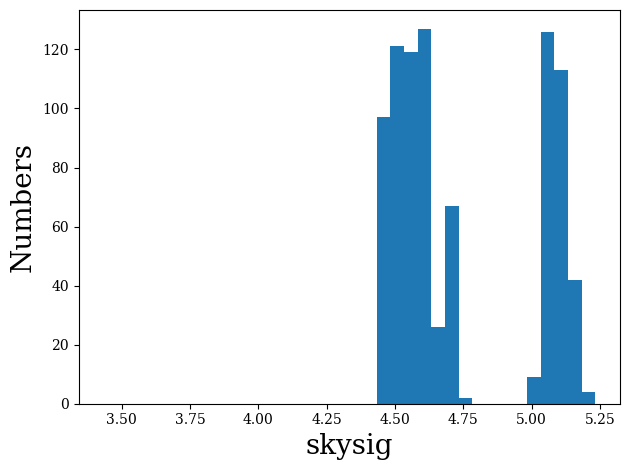

In [40]:
min_skysig, max_skysig = np.min(intbl1['skysig']), np.max(intbl1['skysig'])
bin_min_skysig, bin_max_skysig, step_skysig = 0, 100, 0.05
# bins_skysig = np.arange(bin_min_skysig, bin_max_skysig, step_skysig)
# bins_skysig = np.arange(bin_min_skysig, max_skysig+step_skysig, step_skysig)
bins_skysig = np.arange(min_skysig-1, max_skysig+step_skysig, step_skysig)
_ = plt.hist(intbl1['skysig'], bins=bins_skysig)
plt.xlabel(f"skysig")
plt.ylabel("Numbers")
plt.tight_layout()

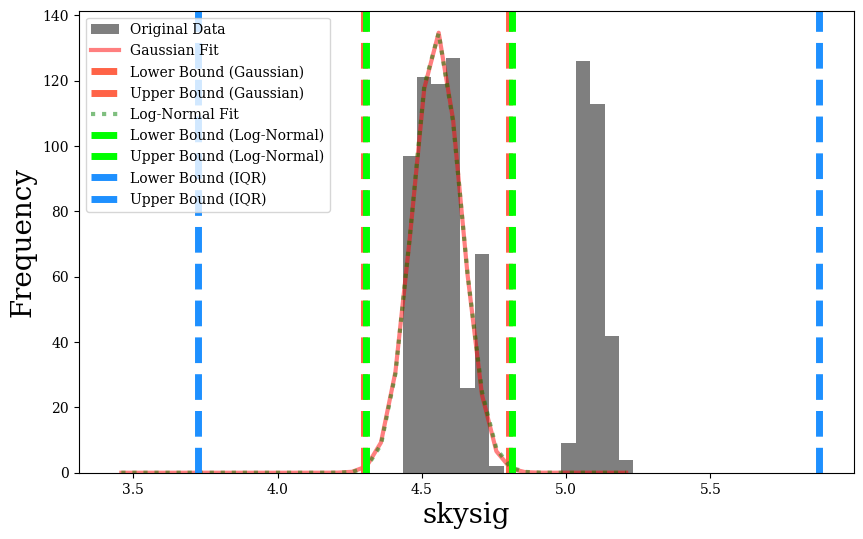

In [41]:
# 예시 코드입니다. 실제 데이터를 사용하기 전에 필요한 수정을 해야 합니다.

from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit

# 데이터 로드
# intbl1 = ... # 여기서 실제 데이터를 로드해야 합니다.
data = intbl1['skysig']

# 가우시안 피팅을 위한 함수
def gaussian(x, amplitude, mean, stddev):
    return amplitude / (stddev * np.sqrt(2 * np.pi)) * np.exp(-((x - mean) ** 2) / (2 * stddev**2))

# 로그-정규 피팅을 위한 함수
def lognormal(x, amplitude, mean, stddev):
    return amplitude / (x * stddev * np.sqrt(2 * np.pi)) * np.exp(-((np.log(x) - mean) ** 2) / (2 * stddev**2))

# 히스토그램 데이터를 사용하여 피팅
hist, bin_edges = np.histogram(data, bins=bins_skysig)#, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 초기 추정값 설정
init_vals_gauss = [1, np.median(data), np.std(data)]
init_vals_lognorm = [1, np.mean(np.log(data)), np.std(np.log(data))]

# 피팅 실행
popt_gauss, pcov_gauss = curve_fit(gaussian, bin_centers, hist, p0=init_vals_gauss)
popt_lognorm, pcov_lognorm = curve_fit(lognormal, bin_centers, hist, p0=init_vals_lognorm)

# IQR 계산
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1

# 이상치 제거 기준 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치가 아닌 데이터 선택
filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

# Gaussian
amplitude, mean_gauss, stddev_gauss = popt_gauss
lower_bound_gauss = mean_gauss - stddev_gauss*n_sigma
upper_bound_gauss = mean_gauss + stddev_gauss*n_sigma
filtered_data_gaussian = data[(data >= lower_bound_gauss) & (data <= upper_bound_gauss)]

# Log-Norm
amplitude, mean_lognorm, stddev_lognorm = popt_lognorm
lower_bound_lognorm = np.exp(mean_lognorm - stddev_lognorm*n_sigma)
upper_bound_lognorm = np.exp(mean_lognorm + stddev_lognorm*n_sigma)
filtered_data_lognorm = data[(data >= lower_bound_lognorm) & (data <= upper_bound_lognorm)]


# 결과 출력
# print("Filtered data using IQR:", filtered_data)

# 플롯 생성
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins_skysig, alpha=0.5, color='k', label='Original Data')
#   Fitting
plt.plot(bin_centers, gaussian(bin_centers, *popt_gauss), 'r-', lw=3, alpha=0.5, label='Gaussian Fit')
plt.axvline(x=lower_bound_gauss, color='tomato', linestyle='--', lw=5, label='Lower Bound (Gaussian)')
plt.axvline(x=upper_bound_gauss, color='tomato', linestyle='--', lw=5, label='Upper Bound (Gaussian)')

plt.plot(bin_centers, lognormal(bin_centers, *popt_lognorm), 'g:', lw=3, alpha=0.5, label='Log-Normal Fit')
plt.axvline(x=lower_bound_lognorm, color='lime', linestyle='--', lw=5, label='Lower Bound (Log-Normal)')
plt.axvline(x=upper_bound_lognorm, color='lime', linestyle='--', lw=5, label='Upper Bound (Log-Normal)')
#   IQR
plt.axvline(x=lower_bound, color='dodgerblue', linestyle='--', lw=5, label='Lower Bound (IQR)')
plt.axvline(x=upper_bound, color='dodgerblue', linestyle='--', lw=5, label='Upper Bound (IQR)')
plt.xlabel("skysig")
plt.ylabel("Frequency")
plt.legend()
plt.savefig(f"{path_save}/step2_skysig_dist.png")


In [42]:
intbl2 = intbl1[(data <= upper_bound_gauss)]
n_total1 = len(intbl1)
n_step2 = len(intbl2)
print("# Step 2")
print(f"Total: {len(intbl1)}")
print(f"Survived: {n_step2} ({n_step2/n_total1:.1%})")

# if not (n_total == n_step1+n_out):
	# print(n_total - (n_step1+n_out))

# Step 2
Total: 855
Survived: 561 (65.6%)


### Step 3: `seeing`

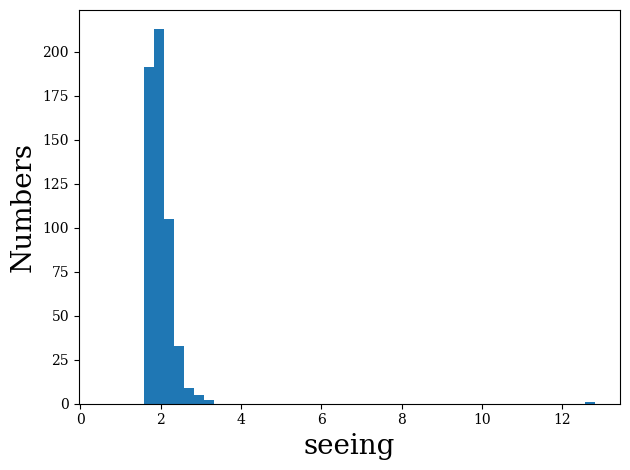

In [43]:
min_seeing, max_seeing = np.min(intbl2['seeing']), np.max(intbl2['seeing'])
bin_min_seeing, bin_max_seeing, step_seeing = 0, 100, 0.25
bins_seeing = np.arange(min_seeing-1, max_seeing+step_seeing, step_seeing)
_ = plt.hist(intbl2['seeing'], bins=bins_seeing)
plt.xlabel(f"seeing")
plt.ylabel("Numbers")
plt.tight_layout()

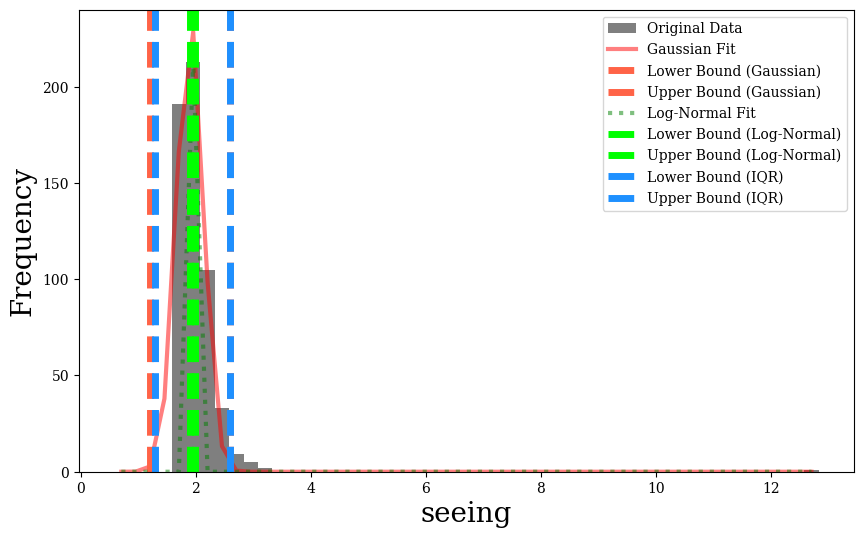

In [44]:
# 예시 코드입니다. 실제 데이터를 사용하기 전에 필요한 수정을 해야 합니다.

from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit

# 데이터 로드
data = intbl2['seeing']

# 가우시안 피팅을 위한 함수
def gaussian(x, amplitude, mean, stddev):
    return amplitude / (stddev * np.sqrt(2 * np.pi)) * np.exp(-((x - mean) ** 2) / (2 * stddev**2))

# 로그-정규 피팅을 위한 함수
def lognormal(x, amplitude, mean, stddev):
    return amplitude / (x * stddev * np.sqrt(2 * np.pi)) * np.exp(-((np.log(x) - mean) ** 2) / (2 * stddev**2))

# 히스토그램 데이터를 사용하여 피팅
hist, bin_edges = np.histogram(data, bins=bins_seeing)#, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 초기 추정값 설정
init_vals_gauss = [1, np.median(data), np.std(data)*2]
init_vals_lognorm = [1, np.mean(np.log(data)), np.std(np.log(data))*2]

# 피팅 실행
popt_gauss, pcov_gauss = curve_fit(gaussian, bin_centers, hist, p0=init_vals_gauss)
popt_lognorm, pcov_lognorm = curve_fit(lognormal, bin_centers, hist, p0=init_vals_lognorm)

# IQR 계산
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1

# 이상치 제거 기준 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치가 아닌 데이터 선택
filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

# Gaussian
amplitude, mean_gauss, stddev_gauss = popt_gauss
lower_bound_gauss = mean_gauss - stddev_gauss*n_sigma
upper_bound_gauss = mean_gauss + stddev_gauss*n_sigma
filtered_data_gaussian = data[(data >= lower_bound_gauss) & (data <= upper_bound_gauss)]

# Log-Norm
amplitude, mean_lognorm, stddev_lognorm = popt_lognorm
lower_bound_lognorm = np.exp(mean_lognorm - stddev_lognorm*n_sigma)
upper_bound_lognorm = np.exp(mean_lognorm + stddev_lognorm*n_sigma)
filtered_data_lognorm = data[(data >= lower_bound_lognorm) & (data <= upper_bound_lognorm)]


# 결과 출력
# print("Filtered data using IQR:", filtered_data)

# 플롯 생성
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins_seeing, alpha=0.5, color='k', label='Original Data')
#   Fitting
plt.plot(bin_centers, gaussian(bin_centers, *popt_gauss), 'r-', lw=3, alpha=0.5, label='Gaussian Fit')
plt.axvline(x=lower_bound_gauss, color='tomato', linestyle='--', lw=5, label='Lower Bound (Gaussian)')
plt.axvline(x=upper_bound_gauss, color='tomato', linestyle='--', lw=5, label='Upper Bound (Gaussian)')

plt.plot(bin_centers, lognormal(bin_centers, *popt_lognorm), 'g:', lw=3, alpha=0.5, label='Log-Normal Fit')
plt.axvline(x=lower_bound_lognorm, color='lime', linestyle='--', lw=5, label='Lower Bound (Log-Normal)')
plt.axvline(x=upper_bound_lognorm, color='lime', linestyle='--', lw=5, label='Upper Bound (Log-Normal)')
#   IQR
plt.axvline(x=lower_bound, color='dodgerblue', linestyle='--', lw=5, label='Lower Bound (IQR)')
plt.axvline(x=upper_bound, color='dodgerblue', linestyle='--', lw=5, label='Upper Bound (IQR)')
plt.xlabel("seeing")
plt.ylabel("Frequency")
plt.legend()
plt.savefig(f"{path_save}/step3_seeing_dist.png")


In [45]:
intbl3 = intbl2[(data <= upper_bound_gauss)]
n_total2 = len(intbl2)
n_step3 = len(intbl3)
print("# Step 3")
print(f"Total: {len(intbl2)}")
print(f"Survived: {n_step3} ({n_step3/n_total2:.1%})")

# if not (n_total == n_step1+n_out):
	# print(n_total - (n_step1+n_out))

# Step 3
Total: 561
Survived: 544 (97.0%)


### Summary

In [46]:
outbl = intbl3.copy()

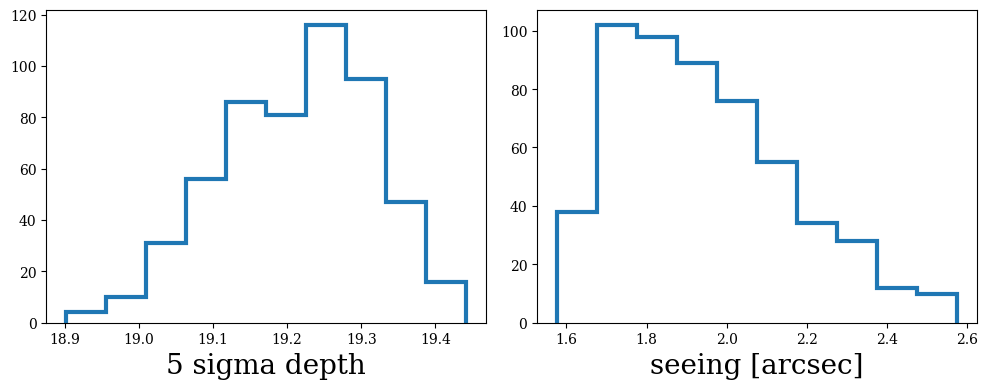

In [47]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(outbl['ul5_1'], histtype='step', lw=3)
plt.xlabel(f"5 sigma depth")
plt.subplot(122)
plt.hist(outbl['seeing'], histtype='step', lw=3)
plt.xlabel("seeing [arcsec]")
plt.tight_layout()
plt.savefig(f"{path_save}/filtered_seeing_depth_dist.png")

In [48]:
summary_text = f"""Original: {len(intbl)}
-----------------------------------
Step1   : {n_step1}, {n_total-n_step1} rejected ({n_step1/n_total:.1%})
Step2   : {n_step2}, {n_total-n_step2} rejected ({n_step2/n_total1:.1%})
Step3   : {n_step3}, {n_total-n_step3} rejected ({n_step3/n_total2:.1%})
-----------------------------------
Final   : {n_step3}/{n_total} ({n_step3/n_total:.1%})"""
print(summary_text)

logfile = f"{path_save}/log.txt"
f = open(logfile, "w")
f.write(summary_text)
f.close()

Original: 1243
-----------------------------------
Step1   : 855, 388 rejected (68.8%)
Step2   : 561, 682 rejected (65.6%)
Step3   : 544, 699 rejected (97.0%)
-----------------------------------
Final   : 544/1243 (43.8%)


In [49]:
outbl.write(f"{path_save}/filtered_image_header.csv", format='csv', overwrite=True)

In [50]:
image_files_txt = f"{path_save}/image.list"
g = open(image_files_txt, "w")
for inim in outbl['file']:
	g.write(f"{inim}\n")
g.close()

In [51]:
outbl[:3]

file,simple,bitpix,naxis,naxis1,naxis2,extend,origin,date,imagetyp,exposure,exptime,date-loc,date-obs,xbinning,ybinning,gain,egain,xpixsz,ypixsz,instrume,set-temp,ccd-temp,telescop,focallen,focratio,ra,dec,centalt,centaz,airmass,pierside,siteelev,sitelat,sitelong,fwheel,filter,object,objctra,objctdec,objctrot,focname,focpos,focuspos,focussz,roworder,equinox,swcreate,radesys,ctype1,ctype2,cunit1,cunit2,crval1,crval2,crpix1,crpix2,cd1_1,cd1_2,cd2_1,cd2_2,pv1_0,pv1_1,pv1_2,pv1_4,pv1_5,pv1_6,pv1_7,pv1_8,pv1_9,pv1_10,pv2_0,pv2_1,pv2_2,pv2_4,pv2_5,pv2_6,pv2_7,pv2_8,pv2_9,pv2_10,fgroupno,astirms1,astirms2,astrrms1,astrrms2,astinst,flxscale,magzerop,photirms,photinst,photlink,racent,deccent,rapoly0,depoly0,rapoly1,depoly1,rapoly2,depoly2,rapoly3,depoly3,rotang1,rotang2,author,photime,jd,mjd,seeing,peeing,ellip,elong,skysig,skyval,refcat,maglow,magup,stdnumb,auto,aper,aper_1,aper_2,aper_3,aper_4,aper_5,zp_auto,ezp_auto,ul3_auto,ul5_auto,zp_0,ezp_0,ul3_0,ul5_0,zp_1,ezp_1,ul3_1,ul5_1,zp_2,ezp_2,ul3_2,ul5_2,zp_3,ezp_3,ul3_3,ul5_3,zp_4,ezp_4,ul3_4,ul5_4,zp_5,ezp_5,ul3_5,ul5_5,comment,history,cloudcvr,dewpoint,humidity,pressure,skybrght,mpsas,skytemp,starfwhm,ambtemp,winddir,windgust,windspd,row_index
str81,str4,int64,int64,int64,int64,str4,str27,str23,str5,float64,float64,str23,str23,int64,int64,int64,float64,float64,float64,str19,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,str19,str4,str3,str8,str9,float64,str20,int64,int64,float64,str8,float64,str19,str4,str8,str8,str3,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str17,str10,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str64,str57,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
/large_data/processed/UDS/7DT05/m575/calib_7DT05_UDS_20231106_080527_m575_60.fits,True,-32,2,9576,6388,True,Eclair v0.9 25 October 2019,2023-12-13T23:25:20.424,LIGHT,60.0,60.0,2023-11-06T05:05:27.266,2023-11-06T08:05:27.266,1,1,1,0.779809474945068,3.76,3.76,Moravian USB Camera,-15.0,-14.9939727783203,7DT05,1537.0,3.0,34.4041720560088,-5.05331956638273,27.042114364045,280.820292620087,2.19139833454233,East,1600.0,-30.4713333333333,-70.7649444444445,Moravian USB Filter,m575,UDS,02 17 37,-05 03 12,0.0,PlaneWave Focuser (v,6438,6438,1.0,TOP-DOWN,2000.0,N.I.N.A. 2.2.0.9001,--,RA---TPV,DEC--TPV,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,682
/large_data/processed/UDS/7DT05/m575/calib_7DT05_UDS_20231206_011302_m575_60.fits,True,-32,2,9576,6388,True,Eclair v0.9 25 October 2019,2023-12-14T01:14:52.398,LIGHT,60.0,60.0,2023-12-05T22:13:02.446,2023-12-06T01:13:02.446,1,1,1,0.779809474945068,3.76,3.76,Moravian USB Camera,-15.0,-15.0027618408203,7DT05,1537.0,3.0,34.4041431336882,-5.05332845372581,61.9407805748494,27.0083623287732,1.13280481467435,East,1600.0,-30.4713333333333,-70.7649444444445,Moravian USB Filter,m575,UDS,02 17 37,-05 03 12,0.0,PlaneWave Focuser (v,6419,6419,1.0,TOP-DOWN,2000.0,N.I.N.A. 2.2.0.9001,ICRS,RA---TPV,DEC--T